EXPERIMENT:
- KAIROS uses an encoder decoder architecture trained on benign data
    - 'learning what benign data looks like'
    - low reconstruction error: = benign
    - high reconstruction error: = anomaly, possible threat

- train an encoder decoder on graph node feature vectors:
- a feature vector contains N values sampled from a specific distribution:
    - 'benign' distribution
    - 'drifting' distribution
    - 'threat' distribution

    - the 'benign' distribution has some overlap with the 'drifting' distribution
    - the 'benign' distribution, and the 'threat' distribution have no overlap

GOAL:
- As we experience concept drift, we want to learn the new benign behavour while still accurately detecting threats
- Reduce false positives, maintain accuracy
- Also, do we want to minimize performance loss on old, benign data? (depends on the nature of the concept drift, probably out of scope for this project)

Scenario A, NO CONCEPT DRIFT
- initially train on 'benign' only
- evaluate on 'threat' and 'benign' samples
- EXPECTED RESULT: should be pretty good

Scenario B, EFFECTS OF CONCEPT DRIFT
- initially train on 'benign' only
- evaluate on 'drifting' and 'threat' samples
- EXPECTED RESULT: should be worse than A (more false positives)

Scenario C, RE-TRAINING AFTER M NUMBER OF FALSE POSITIVES (specified by human patience) ->  KAIROS
- initially train on 'benign' only
- evaluate on 'drifting' and 'threat' samples (as if deployed in a real detection environment)
- after M number of false positives, re-train or resume training (using data seen thus far)
- evaluate on more (unseen) 'drifting' and 'threat' samples
- IMPORTANT: plot accuracy and false positives over time, mark the point where we re-trained
- EXPECTED RESULT: should be better than B (less false positives)

Scenario D, SUPERVISED LEARNING WITH HUMAN FEEDBACK
- initially train on 'benign' only
- use HUMAN FEEDBACK on 'drifting' and 'threat' samples (as if deployed in a real detection environment)
- IMPORTANT: plot accuracy and false positives over time, mark the point where we started using human feedback
- EXPECTED RESULT: should be better than C (less false positives)




In [ ]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from Data import DistDataset
from Distributions import BENIGN, DRIFTING, THREAT, is_threat
from tqdm import tqdm
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [30]:
def plot_FP(FP_history):
    # Plot the false positives over time
    plt.plot(FP_history)
    plt.xlabel('Sample Index')
    plt.ylabel('Cumulative False Positives')
    plt.title('Cumulative False Positives Over Time')
    plt.grid(True)
    plt.ylim(0, 1000)
    plt.show()

In [31]:
# load our datasets
NodeFeatureLen = 10
NumNodesPerDatasetTRAIN = 20000
NumNodesPerDatasetVAL = 10000
NumNodesPerDatasetTEST = 10000


benign_train_dataset = DistDataset(BENIGN(), NodeFeatureLen, NumNodesPerDatasetTRAIN)
benign_val_dataset = DistDataset(BENIGN(), NodeFeatureLen, NumNodesPerDatasetVAL)
benign_test_dataset = DistDataset(BENIGN(), NodeFeatureLen, NumNodesPerDatasetTEST)

threat_dataset = DistDataset(THREAT(), NodeFeatureLen, NumNodesPerDatasetTEST)


A_test = torch.utils.data.ConcatDataset([benign_test_dataset, threat_dataset])


drifting_train_dataset = DistDataset(DRIFTING(), NodeFeatureLen, NumNodesPerDatasetTRAIN)
drifting_test_dataset = DistDataset(DRIFTING(), NodeFeatureLen, NumNodesPerDatasetTEST)


B_test = torch.utils.data.ConcatDataset([drifting_test_dataset, threat_dataset])


In [32]:
# define the model architecture to be used for the experiments

class Baseline(nn.Module):
    def __init__(self, NodeFeatureLen):
        super(Baseline, self).__init__()
        self.encode1 = nn.Linear(NodeFeatureLen, 32)
        self.encode2 = nn.Linear(32, 64)
        self.encode3 = nn.Linear(64, 128)

        self.decode1 = nn.Linear(128, 64)
        self.decode2 = nn.Linear(64, 32)
        self.decode3 = nn.Linear(32, NodeFeatureLen)

        # self.encode1 = nn.Linear(NodeFeatureLen, 64)
        # self.encode2 = nn.Linear(64, 32)
        # self.encode3 = nn.Linear(32, 16)

        # self.decode1 = nn.Linear(16, 32)
        # self.decode2 = nn.Linear(32, 64)
        # self.decode3 = nn.Linear(64, NodeFeatureLen)

    def forward(self, x):
        x = F.relu(self.encode1(x))
        x = F.relu(self.encode2(x))
        x = F.relu(self.encode3(x))

        x = F.relu(self.decode1(x))
        x = F.relu(self.decode2(x))
        x = self.decode3(x)
        return x

In [33]:
# Scenario A, NO CONCEPT DRIFT
# - initially train on 'benign' only
# - evaluate on 'threat' and 'benign' samples
device = 'cpu'
model_A = Baseline(NodeFeatureLen).to(device)
epochs_A = 10
optimizer_A = optim.Adam(model_A.parameters(), lr=1e-3)
batch_size_A = 100


def train_A(model, epochs, trainloader, valloader, optimizer, device):
    print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")
    itrs = tqdm(range(epochs))
    itrs.set_description("Train Loss: ? - Val Loss: ?")
    best_loss = float("inf")

    for epoch in itrs:
        avg_train_loss = 0.0
        batch_num = 0
        for batch in trainloader:
            batch_num+=1
            # print(f"Training on batch {batch_num} / {len(trainloader)}")
            batch_x = batch.to(device)

            optimizer.zero_grad()

            pred = model(batch_x)

            loss = F.mse_loss(pred, batch_x) # reconstruction loss

            loss.backward()
            optimizer.step()

            avg_train_loss += loss.item()

        avg_train_loss /= len(trainloader)

        # validating and saving the model
        with torch.no_grad():
            avg_val_loss = 0.0
            batch_num = 0
            for val_batch in valloader:
                batch_num+=1
                # print(f"Validating on batch {batch_num} / {len(valloader)}")
                batch_val_x = val_batch.to(device)

                pred = model(batch_val_x)

                loss = F.mse_loss(pred, batch_val_x) # reconstruction loss

                avg_val_loss += loss.item()

            avg_val_loss /= len(valloader)

        itrs.set_description(
            f"Train Loss on BENIGN: {avg_train_loss:.3f} - Val Loss on BENIGN: {avg_val_loss:.3f}"
        )

        # print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.3f} - Val Loss: {avg_val_loss:.3f}")

        # save the model on the best validation loss
        if best_loss > avg_val_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "Model_A.pt")
            torch.save(optimizer.state_dict(), "Optim_A.pt")

train_A(model_A, 
        epochs_A, 
        trainloader=DataLoader(benign_train_dataset, batch_size=batch_size_A), 
        valloader=DataLoader(benign_val_dataset, batch_size=batch_size_A), optimizer=optimizer_A, device=device)


def get_losses(model, testloader, device, string):
    with torch.no_grad():
        avg_val_loss = 0.0
        max_loss = 0
        min_loss = float('inf')

        batch_num = 0
        for val_batch in testloader:
            batch_num+=1
            # print(f"Validating on batch {batch_num} / {len(valloader)}")
            batch_val_x = val_batch.to(device)

            pred = model(batch_val_x)

            loss = F.mse_loss(pred, batch_val_x) # reconstruction loss
            if loss.item() > max_loss:
                max_loss = loss.item()
            if loss.item() < min_loss:
                min_loss = loss.item()

            avg_val_loss += loss.item()

        avg_val_loss /= len(testloader)

    print(f"Max loss on {string}: {max_loss} Min: {min_loss} Avg: {avg_val_loss}")
    return avg_val_loss, max_loss, min_loss


def eval(model, testloader, device, threshold, datasetstr):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    FP_history = []
    with torch.no_grad():
        avg_val_loss = 0.0
        batch_num = 0
        for val_batch in testloader:
            batch_num+=1
            # print(f"Validating on batch {batch_num} / {len(valloader)}")
            batch_val_x = val_batch.to(device)

            pred = model(batch_val_x)
            # print("pred ", pred)
            # print("actual ", batch_val_x)
            it = is_threat(batch_val_x)

            loss = F.mse_loss(pred, batch_val_x) # reconstruction loss BUT WE SHOULDN'T USE THIS ON EVAL, instead we should track TP FP TN FN

            

            if loss > threshold: # use the typical loss on the validation set
                # this is a threat
                # if it's actually a threat, TP
                if it:
                    TP+=1
                # else, FP
                else:
                    FP+=1
            else:
                # this is not a threat
                # if it's not actually a threat, TN
                if not it:
                    TN+=1
                # if it's actually a threat, FN
                else:
                    FN+=1
            FP_history.append(FP)
            avg_val_loss += loss.item()

        avg_val_loss /= len(testloader)

    print(f"Test Loss on {datasetstr}: {avg_val_loss:.3f}")
    print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")
    plot_FP(FP_history)
        



model_A.load_state_dict(torch.load("Model_A.pt"))
model_A = model_A.to(device)

# determine threshold for benign data
max_loss_on_valid = get_losses(model_A, DataLoader(benign_val_dataset, batch_size=1), device=device, string="BENIGN VALIDATION SET")[1]


do_not_use2 = get_losses(model_A, DataLoader(benign_test_dataset, batch_size=1), device=device, string="BENIGN TEST SET")[1]
do_not_use2 = get_losses(model_A, DataLoader(drifting_test_dataset, batch_size=1), device=device, string="DRIFTING TEST SET")[1]
do_not_use = get_losses(model_A, DataLoader(threat_dataset, batch_size=1), device=device, string="THREAT TEST SET")[1]






Model has 21450 parameters


Train Loss on BENIGN: 0.069 - Val Loss on BENIGN: 0.037: 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]  
C:\Users\Curtis\AppData\Local\Temp\ipykernel_6116\3867344824.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for an

Max loss on BENIGN VALIDATION SET: 6.869399070739746 Min: 0.005932858679443598 Avg: 0.03267429685397073
Max loss on BENIGN TEST SET: 7.007869720458984 Min: 0.006906005088239908 Avg: 0.0340613261426799
Max loss on DRIFTING TEST SET: 2.408745288848877 Min: 0.15265531837940216 Avg: 0.5125268018811941
Max loss on THREAT TEST SET: 30.765233993530273 Min: 12.193862915039062 Avg: 20.89045119943619


Test Loss on BENIGN + THREAT: 10.462
TP: 10000, FP: 97, TN: 9903, FN: 0


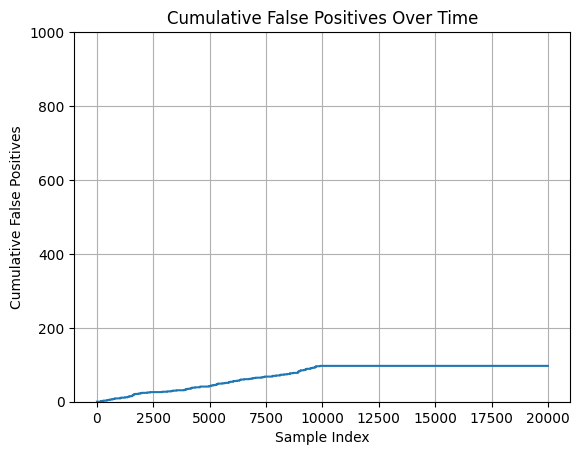

In [34]:
eval(model_A, 
       testloader=DataLoader(A_test, batch_size=1),
       device=device, threshold=0.5, datasetstr = "BENIGN + THREAT")

Test Loss on DRIFTING + THREAT: 10.701
TP: 10000, FP: 5288, TN: 4712, FN: 0


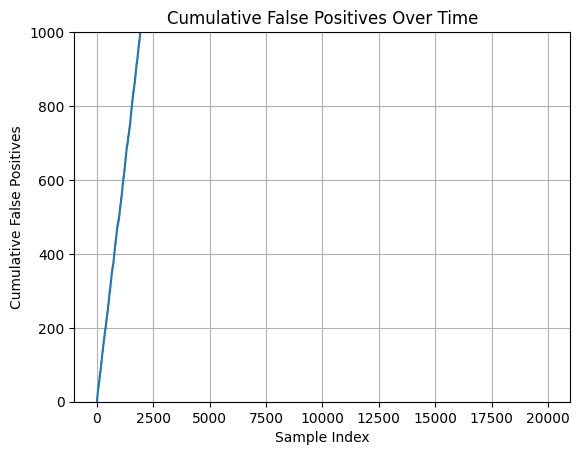

In [35]:
# Scenario B
# Scenario B, EFFECTS OF CONCEPT DRIFT
# - initially train on 'benign' only
# - evaluate on 'drifting' and 'threat' samples
# - EXPECTED RESULT: should be worse than A (more false positives)
drifting_threat_loader = DataLoader(B_test, batch_size=1)
eval(model_A, 
       testloader=drifting_threat_loader,
       device=device, threshold=0.5, datasetstr="DRIFTING + THREAT")


C:\Users\Curtis\AppData\Local\Temp\ipykernel_6116\619796093.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_A.load_state_dict(torch.load("Model_A.pt"))


hit 50 FP at sample number 90/20000, pausing eval to train
Model has 21450 parameters


Train Loss on new data: 0.014: 100%|██████████| 10/10 [00:00<00:00, 24.99it/s]


Test Loss on DRIFTING + THREAT: 0.843
TP: 10000, FP: 56, TN: 9944, FN: 0


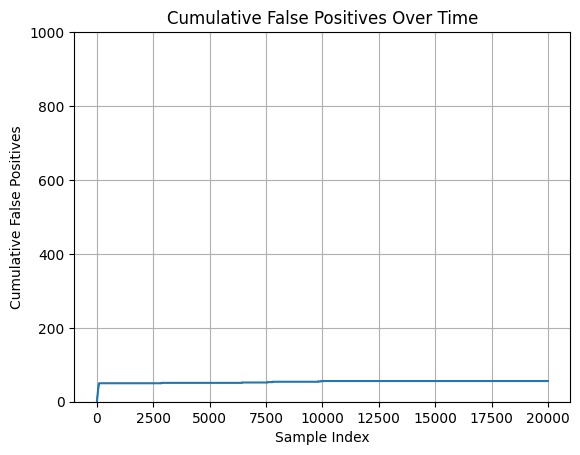

In [36]:
# Scenario C
# Scenario C, RE-TRAINING AFTER M NUMBER OF FALSE POSITIVES (specified by human patience) ->  KAIROS
# - initially train on 'benign' only
# - evaluate on 'drifting' and 'threat' samples (as if deployed in a real detection environment)
# - after M number of false positives, re-train or resume training (using data seen thus far)
# - evaluate on more (unseen) 'drifting' and 'threat' samples
# - IMPORTANT: plot accuracy and false positives over time, mark the point where we re-trained
# - EXPECTED RESULT: should be better than B (less false positives)

def train_C(model, epochs, trainloader, optimizer, device):
    print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")
    itrs = tqdm(range(epochs))
    itrs.set_description("Train Loss: ? - Val Loss: ?")
    best_loss = float("inf")
    with torch.set_grad_enabled(True):
        for epoch in itrs:
            avg_train_loss = 0.0
            batch_num = 0
            for batch in trainloader:
                batch_num+=1
                # print(f"Training on batch {batch_num} / {len(trainloader)}")
                batch_x = batch.to(device)

                optimizer.zero_grad()

                pred = model(batch_x)

                loss = F.mse_loss(pred, batch_x) # reconstruction loss

                loss.backward()
                optimizer.step()

                avg_train_loss += loss.item()

            avg_train_loss /= len(trainloader)


            itrs.set_description(
                f"Train Loss on new data: {avg_train_loss:.3f}"
            )
    return model



def eval_C(model, testloader, device, threshold, datasetstr, optim):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    FP_history = []
    data_points_for_additional_training = []
    have_re_trained = False
    with torch.no_grad():
        avg_val_loss = 0.0
        batch_num = 0
        for val_batch in testloader:
            batch_num+=1
            # print(f"Validating on batch {batch_num} / {len(valloader)}")
            batch_val_x = val_batch.to(device)

            pred = model(batch_val_x)
            # print("pred ", pred)
            # print("actual ", batch_val_x)
            it = is_threat(batch_val_x)

            loss = F.mse_loss(pred, batch_val_x) # reconstruction loss BUT WE SHOULDN'T USE THIS ON EVAL, instead we should track TP FP TN FN


            if loss > threshold: # use the typical loss on the validation set
                # this is a threat
                # if it's actually a threat, TP
                if it:
                    TP+=1
                # else, FP
                else:
                    data_points_for_additional_training.append(batch_val_x)
                    FP+=1
            else:
                # this is not a threat
                # if it's not actually a threat, TN
                if not it:
                    TN+=1
                    # data_points_for_additional_training.append(batch_val_x)
                # if it's actually a threat, FN
                else:
                    FN+=1
            FP_history.append(FP)
            avg_val_loss += loss.item()

            
            
            # check if we hit M number of FP's
            if FP == 50 and not have_re_trained:
                print(f"hit 50 FP at sample number {batch_num}/{len(testloader)}, pausing eval to train")   
                model = train_C(model, 10, data_points_for_additional_training , optim, device)
                have_re_trained = True
            # then, resume the evaluation

        avg_val_loss /= len(testloader)

    print(f"Test Loss on {datasetstr}: {avg_val_loss:.3f}")
    print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")
    plot_FP(FP_history)


drifting_threat_loader = DataLoader(B_test, batch_size=1)
model_A.load_state_dict(torch.load("Model_A.pt"))
# optimizer_A.load_state_dict(torch.load("Optim_A.pt"))
optimizer_A = optim.Adam(model_A.parameters(), lr=1e-7)
model_A = model_A.to(device)
eval_C(model_A, 
       testloader=drifting_threat_loader,
       device=device, threshold=0.5, datasetstr="DRIFTING + THREAT", optim=optimizer_A)


C:\Users\Curtis\AppData\Local\Temp\ipykernel_6116\2113114219.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_A.load_state_dict(torch.load("Model_A.pt"))


Validating on batch 1 / 20000 current FP: 0
Validating on batch 2 / 20000 current FP: 1
Validating on batch 3 / 20000 current FP: 1
Validating on batch 4 / 20000 current FP: 1
Validating on batch 5 / 20000 current FP: 1
Validating on batch 6 / 20000 current FP: 1
Validating on batch 7 / 20000 current FP: 1
Validating on batch 8 / 20000 current FP: 1
Validating on batch 9 / 20000 current FP: 1
Validating on batch 10 / 20000 current FP: 1
Validating on batch 11 / 20000 current FP: 1
Validating on batch 12 / 20000 current FP: 1
Validating on batch 13 / 20000 current FP: 1
Validating on batch 14 / 20000 current FP: 1
Validating on batch 15 / 20000 current FP: 1
Validating on batch 16 / 20000 current FP: 1
Validating on batch 17 / 20000 current FP: 1
Validating on batch 18 / 20000 current FP: 1
Validating on batch 19 / 20000 current FP: 1
Validating on batch 20 / 20000 current FP: 1
Validating on batch 21 / 20000 current FP: 1
Validating on batch 22 / 20000 current FP: 1
Validating on batch

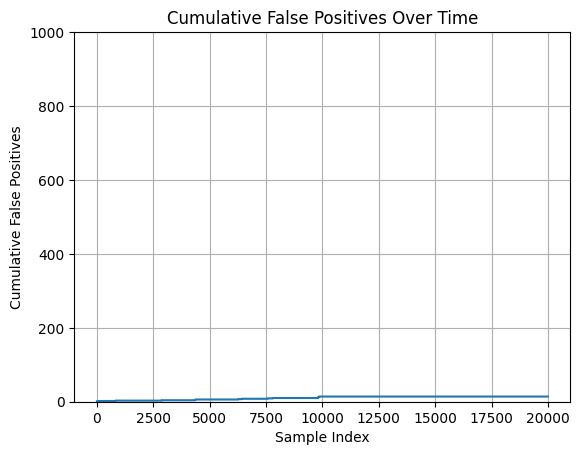

In [37]:
# Scenario D
# Scenario D, SUPERVISED LEARNING WITH HUMAN FEEDBACK
# - initially train on 'benign' only
# - use HUMAN FEEDBACK on 'drifting' and 'threat' samples (as if deployed in a real detection environment), maybe as a bonus, add 'drifted' samples near the end
# - IMPORTANT: plot accuracy and false positives over time, mark the point where we started using human feedback
# - EXPECTED RESULT: should be better than C (less false positives)

# aka, re-train with one sample X times




def train_D(model, epochs, trainloader, optimizer, device):
    print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")
    itrs = tqdm(range(epochs))
    itrs.set_description("Train Loss: ? - Val Loss: ?")
    best_loss = float("inf")
    with torch.set_grad_enabled(True):
        for epoch in itrs:
            avg_train_loss = 0.0
            batch_num = 0
            for batch in trainloader:
                batch_num+=1
                # print(f"Training on batch {batch_num} / {len(trainloader)}")
                batch_x = batch.to(device)

                optimizer.zero_grad()

                pred = model(batch_x)

                loss = F.mse_loss(pred, batch_x) # reconstruction loss

                loss.backward()
                optimizer.step()

                avg_train_loss += loss.item()

            avg_train_loss /= len(trainloader)


            itrs.set_description(
                f"Train Loss on new data: {avg_train_loss:.3f}"
            )
    return model



def eval_D(model, testloader, device, threshold, datasetstr, optim):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    FP_history = []
    replay_buffer = []
    with torch.set_grad_enabled(True):
        avg_val_loss = 0.0
        batch_num = 0
        for val_batch in testloader:
            batch_num+=1
            print(f"Validating on batch {batch_num} / {len(testloader)} current FP: {FP}")
            batch_val_x = val_batch.to(device)

            pred = model(batch_val_x)
            # print("pred ", pred)
            # print("actual ", batch_val_x)
            it = is_threat(batch_val_x)

            loss = F.mse_loss(pred, batch_val_x) # reconstruction loss BUT WE SHOULDN'T USE THIS ON EVAL, instead we should track TP FP TN FN


            if loss.item() > threshold: # use the typical loss on the validation set
                # this is a threat
                # if it's actually a threat, TP
                if it:
                    TP+=1
                # else, FP
                else:
                    replay_buffer.append(batch_val_x)
                    if len(replay_buffer) > 10:
                        replay_buffer = replay_buffer[1:]

                    while True:

                        optim.zero_grad()
                        pred = model(batch_val_x)
                        loss2 = F.mse_loss(pred, batch_val_x)
                        loss2.backward()
                        optim.step()

                        if loss2.item() < threshold:
                            break



                    # model, optim = train_D(model, 10, replay_buffer, optim, device)
                    FP+=1
                    # print(FP)
            else:
                # this is not a threat
                # if it's not actually a threat, TN
                if not it:
                    # replay_buffer.append(batch_val_x)
                    # if len(replay_buffer) < 50:
                    #     replay_buffer = replay_buffer[1:]
                    # model, _ = train_D(model, 1, replay_buffer, optim, device)
                    TN+=1
                # if it's actually a threat, FN
                else:
                    FN+=1

            FP_history.append(FP)

            avg_val_loss += loss.item()

        avg_val_loss /= len(testloader)

    print(f"Test Loss on {datasetstr}: {avg_val_loss:.3f}")
    print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")
    plot_FP(FP_history)


drifting_threat_loader = DataLoader(B_test, batch_size=1)
model_A.load_state_dict(torch.load("Model_A.pt"))
# optimizer_A.load_state_dict(torch.load("Optim_A.pt"))
optimizer_A = optim.Adam(model_A.parameters(), lr=1e-6)
model_A = model_A.to(device)
eval_D(model_A, 
       testloader=drifting_threat_loader,
       device=device, threshold=0.5, datasetstr="DRIFTING + THREAT", optim=optimizer_A)

# idea, implement replay buffer of a certain length to allow human feedback to make more than 1 update